# Lecture 7

The **objective** of this lecture is to introduce omitted variable bias through simulation. This lecture will serve as background exploration in advance of the labs around the marginal abatement curves. There are good reasons to create the marginal abatement curves, mainly to synthesize and compare social research.  However, there are limitations to these simple numbers - and the objective of this lab is to show what happens when certain considerations are left out. We will draw incorrect conclusions from simple regressions, when important variables are omitted.

In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt

Let's create some data.  Define the *true* data generating process as:

$$
health_i = 4 + 3 \cdot income_i - 1.5 \cdot wq_i + \epsilon_i
$$

For each individual $i$, their health indicator is determined by a constant, their income, the density of pathogens in the water, and *everything else* packaged up into a random component $\epsilon_i$.  The impact of each is reflected in the coefficients, which I made up.  Notably, there is a positive impact of income on health and a negative impact of pathogen density -- e.g., bacteria in the water -- on health. 

In this process, the pathogen density and income are positively correlated through population density, or urbanization.  In India, for example, urban areas have higher levels of income and also a higher density of open defecation - there are more people in less area.


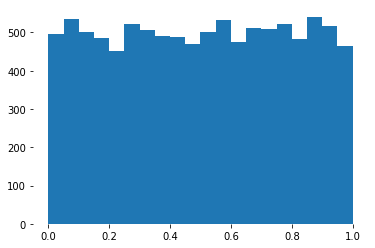

In [134]:
# Make up some data around urbanization. This shape does not reflect reality, 
# but it is convenient -- a uniform distribution with 10K draws.

# Documentation from numpy.random.rand:
# Create an array of the given shape and populate it with random samples 
# from a uniform distribution over [0,1).

u = numpy.random.rand(10000)
plt.hist(u, bins=20)
plt.box(on=None)

In [135]:
import statsmodels.formula.api as sm

# generate the cofactors and force a positive correlation between the two.
income   = 1 + 3 * u + numpy.random.normal(0, 1, 10000)
pathogen = 6 + 5 * u + numpy.random.normal(0, 1, 10000)

df = pandas.DataFrame(
    {
        "income": income,
        "pathogen": pathogen,
        "health": 4 + 3 * income - 1.5 * pathogen + numpy.random.normal(0, 1, 10000)
    }
)

df

,income,pathogen,health
0,3.593725,11.690507,-3.946503
1,1.470994,9.112625,-5.285525
2,0.748243,6.220172,-3.714594
3,1.388452,8.790921,-5.971186
4,1.826092,6.539510,-0.477034
...,...,...,...
9995,1.993834,5.244762,3.312291
9996,4.006124,9.146641,2.191299
9997,3.019568,6.215321,3.591061
9998,3.522006,11.130315,-2.207451


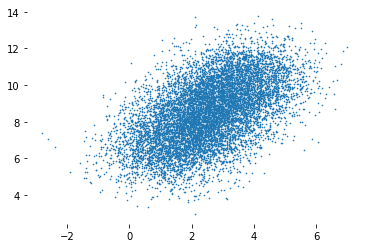

In [137]:
plt.scatter(
    df.income, 
    df.pathogen, 
    s=0.4
)

plt.box(on=None)

In [140]:
result = sm.ols(formula="pathogen ~ income", data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pathogen   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     4073.
Date:                Mon, 28 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:30:09   Log-Likelihood:                -18089.
No. Observations:               10000   AIC:                         3.618e+04
Df Residuals:                    9998   BIC:                         3.620e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7324      0.031    213.933      0.000       6.671       6.794
income         0.7059      0.011     63.819      0.000       0.684       0.728
==============================================================================
Omnibus:                        8.760   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.120
Skew:                          -0.035   Prob(JB):                       0.0172
Kurtosis:                       2.879   Cond. No.                         6.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

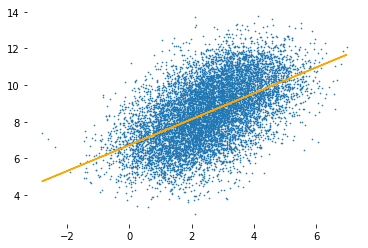

In [148]:
plt.scatter(
    df.income, 
    df.pathogen, 
    s=0.4
)

result = sm.ols(formula="pathogen ~ income", data=df).fit()
m = result.params["income"]
b = result.params["Intercept"]

plt.plot(
    df.income,
    m * df.income + b,
    color="orange"
)


plt.box(on=None)

In [149]:
import statsmodels.formula.api as sm

# run the model with all generating factors
# https://www.statsmodels.org/stable/regression.html
result = sm.ols(formula="health ~ pathogen + income", data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 health   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                 5.879e+04
Date:                Mon, 28 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:32:55   Log-Likelihood:                -14088.
No. Observations:               10000   AIC:                         2.818e+04
Df Residuals:                    9997   BIC:                         2.820e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0026      0.050     80.343      0.000       3.905       4.100
pathogen      -1.4947      0.007   -222.963      0.000      -1.508      -1.482
income         2.9865      0.009    339.548      0.000       2.969       3.004
==============================================================================
Omnibus:                        1.596   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.450   Jarque-Bera (JB):                1.616
Skew:                           0.019   Prob(JB):                        0.446
Kurtosis:                       2.951   Cond. No.                         46.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [157]:
# Create a function to estimate and return the coefficient on pathogen

def simulation_run(n = 100, f = "health ~ pathogen + income"):
    """ Accepts the number of observations for each sample and the 
    definition of the regression, per statsmodels spec"""

    u = numpy.random.rand(n)
    income   = 1 + 3 * u + numpy.random.normal(0, 1, n)
    pathogen = 6 + 5 * u + numpy.random.normal(0, 1, n)
    
    df = pandas.DataFrame(
        {
            "income": income,
            "pathogen": pathogen,
            "health": 4 + 3 * income - 1.5 * pathogen + numpy.random.normal(0, 1, n)
        }
    )
    
    result = sm.ols(formula=f, data=df).fit()
    
    return result.params["pathogen"]

In [159]:
# Run the simulation, number of iterations 10K, n=100
B_range = range(10000)
res_low = [simulation_run() for b in B_range]

In [160]:
# Run the simulation, number of iterations 10K, n=1000
res_high = [simulation_run(n=1000) for b in B_range]

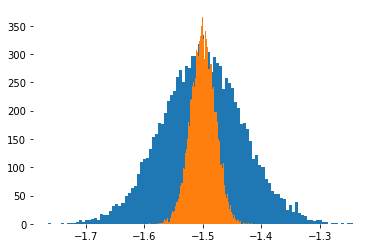

In [163]:
# The higher the number of iterations, the smoother the histogram.
# The higher the number of observations for each iteration, the tighter the distribution,
# i.e., less chance to be way off the mean through fewer observations
plt.hist(res_low, bins=100)
plt.hist(res_high, bins=100)
plt.box(on=None)
plt.show()

Waterborne pathogens can be measured.  Income is more difficult to measure at the individual level.  What happens if we omit `income` from the regression.

The impact of income on health is bundled up into the impact estimate of pathogens.  Income has a positive impact on health, while pathogens have a negative impact.  The omission therefore underestimates the magnitude of the impact.  

In [164]:
res_bias = [simulation_run(f="health ~ pathogen") for b in range(10000)]

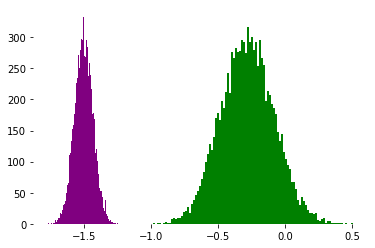

In [165]:
plt.hist(res_low, bins=100, color="purple")
plt.hist(res_bias, bins=100, color="green")
plt.box(on=None)
plt.show()

Two things to note. The bias is determined by the correlation between the error term and the relative variation in the cofactors.  